In [68]:
import glob
import string
import spacy
import jsonlines
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from Utils import *

In [69]:
fs = glob.glob(data_dir + wiki_dir + "*.jsonl")
punc_trans = str.maketrans('', '', string.punctuation)
test_claim_ids = [75397, 150448, 214861, 156709, 129629, 33078, 6744, 226034, 40190, 76253]

In [70]:
# Load claims (can load n non-test samples, loads the 10 test samples by default)
nlp = spacy.load('en', disable=['tagger', 'parser', 'ner', 'entity_linker', 'textcat', 'entity_ruler', 'sentencizer'])
def load_claims(n=10, test=True):
    claims = []
    claims_vocab = set()
    i_ = 0
    with open(data_dir + "train.jsonl", 'r') as f:
        for a_ in jsonlines.Reader(f):
            if (a_["id"] in test_claim_ids) ^ (not test):
                i_ += 1
                claims.append(a_)
                claims[-1]["vocab"] = defaultdict(int)
                for w in a_["claim"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", ''). \
                  translate(punc_trans).split():
#                     w = [token.lemma_ for token in nlp(w)][0]
                    claims[-1]["vocab"][w] += 1
                    claims_vocab.add(w)
            if i_ == n:
                break
    return claims, claims_vocab
claims, claims_vocab = load_claims()
N_claims = len(claims)
N_claims

10

In [ ]:
# Load documents and collect term frequencies
max_number_len = 5            # Ignore words which are simply numbers of this length or longer
max_alphanum_len = 8         # Ignore alphanumeric words which are of this length or longer
def load_line(l):
#     nlp = spacy.load('en', disable=['tagger', 'parser', 'ner', 'entity_linker', 'textcat', 'entity_ruler', 'sentencizer'])
#     return [token.lemma_ for token in nlp(' '.join([
#         w.translate(punc_trans) for w in l.split()[1:] if w != \
#          '' and not ((any(c.isnumeric() for c in w) and len(w) > 7) or \
#                      (w.isnumeric() and len(w) > 5))]))]
#     nlp = spacy.load('en', disable=['tagger', 'parser', 'ner', 'entity_linker', 'textcat', 'entity_ruler', 'sentencizer'])
    return [
        w.translate(punc_trans) for w in l.split()[1:] if w != \
         '' and not ((any(c.isnumeric() for c in w) and len(w) > max_alphanum_len) or \
                     (w.isnumeric() and len(w) > max_number_len))]
def load_docs(vocab, load_tf=False):
    i_ = 0
    wiki = {}
    n_t = defaultdict(int)
    if load_tf: tf = defaultdict(int)
    for fn in fs:
        ids_ = []
        all_lines = []
        with open(fn, 'r') as f:
            for a_ in jsonlines.Reader(f):
                if a_["id"] == "" or a_["lines"] == "":
                    continue
                ids_.append(a_["id"])
                all_lines.append((a_["id"], a_["id"].replace('_', ' ').replace('-LRB-', '').replace('-RRB-', '')
                                  .replace("'s", '').translate(punc_trans) + \
                                  ' '.join([l for l in a_[
                        "lines"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", '').split('\n') if \
                         len(l.split(' ')) > 0 and not (len(l.split(' ')) == 1 and l.strip().isnumeric())])))
        print(len(all_lines))
        all_lines_ = joblib.Parallel(n_jobs=n_cpu, verbose=5)(delayed(load_line)(l) for _, l in all_lines)
#                 l_i = -1
        
        for i in range(len(ids_)):
            id_ = ids_[i]
            l = all_lines_[i]
#                     l_i += 1
#                     if len(l) == 0:
#                         print(a_[
#                         "lines"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", '').split('\n')[l_i])
            doc_tf = defaultdict(int)
            total = 0
            for w in l:
                if load_tf: tf[w] += 1
                if w in vocab:
                    doc_tf[w] += 1
                total += 1
            if total == 0: continue
            for w in set(l):
                n_t[w] += 1
            wiki[id_] = doc_tf, total
        i_ += 1
        if i_ % 100 == 0:
            print("\r" + str(i_) + " / " + str(len(fs)))
    if load_tf:
        return tf, wiki, n_t
    return wiki, n_t
tf, wiki, n_t = load_docs(claims_vocab, load_tf=True)
save_ld((tf, wiki, n_t), "loaded_docs_10c")
# tf, wiki, n_t = load_ld("loaded_docs_10c")
D_ids = list(wiki.keys())
tdist = sorted([(a, b) for (b, a) in list(tf.items())])[::-1]
y = [t[0] for t in tdist]
N_docs = len(wiki)
N = len(y)
mean_doc_len = np.mean([wiki[id_][1] for id_ in wiki])
words_total = sum(tf.values())
c_M = {w: tf[w] / words_total for w in tf}
N_docs, N, mean_doc_len, words_total, c_M["the"], c_M["of"]

48228


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 292 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 48228 out of 48228 | elapsed:    3.1s finished


48178


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 19776 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 48178 out of 48178 | elapsed:    2.3s finished


48973


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 27856 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 48973 out of 48973 | elapsed:    2.7s finished


49174


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 18624 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 49174 out of 49174 | elapsed:    2.7s finished


49578


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 20896 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 49578 out of 49578 | elapsed:    2.7s finished


49719


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 26494 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 49719 out of 49719 | elapsed:    2.7s finished


49849


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 17872 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 49849 out of 49849 | elapsed:    2.9s finished


49948


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 28288 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 49948 out of 49948 | elapsed:    3.2s finished


49933


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 22512 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 49933 out of 49933 | elapsed:    3.0s finished


49920


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 18624 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 49920 out of 49920 | elapsed:    2.9s finished


49928


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 22640 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 49928 out of 49928 | elapsed:    2.8s finished


49904


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 19840 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 49904 out of 49904 | elapsed:    2.7s finished


49921


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 18336 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 49921 out of 49921 | elapsed:    2.6s finished


49930


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 27840 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 49930 out of 49930 | elapsed:    2.9s finished


49923


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 22864 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 49923 out of 49923 | elapsed:    2.9s finished


49928


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 23328 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 49928 out of 49928 | elapsed:    2.9s finished


49936


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 22016 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 49936 out of 49936 | elapsed:    3.0s finished


49954


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 30960 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 49954 out of 49954 | elapsed:    3.1s finished


49923


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 20832 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 49923 out of 49923 | elapsed:    2.6s finished


49931


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 19840 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 49931 out of 49931 | elapsed:    3.1s finished


49939


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 24704 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 49939 out of 49939 | elapsed:    3.1s finished


49931


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 24240 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 49931 out of 49931 | elapsed:    2.9s finished


49883


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 20064 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 49883 out of 49883 | elapsed:    3.1s finished


49887


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 28272 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 49887 out of 49887 | elapsed:    2.9s finished


49904


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 18784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 49904 out of 49904 | elapsed:    2.8s finished


49919


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 20896 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 49919 out of 49919 | elapsed:    3.0s finished


49894


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 22464 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 49894 out of 49894 | elapsed:    2.7s finished


49905


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 19968 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 49905 out of 49905 | elapsed:    2.8s finished


49912


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 21888 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 49912 out of 49912 | elapsed:    2.9s finished


49931


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 23264 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 49931 out of 49931 | elapsed:    2.9s finished


49928


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 19840 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 49928 out of 49928 | elapsed:    3.3s finished


49899


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 27152 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 49899 out of 49899 | elapsed:    3.1s finished


49890


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 27232 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 49890 out of 49890 | elapsed:    2.9s finished


49877


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 22016 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 49877 out of 49877 | elapsed:    2.9s finished


49893


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 24912 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 49893 out of 49893 | elapsed:    2.9s finished


49903


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 17056 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 49903 out of 49903 | elapsed:    2.7s finished


49915


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 26288 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 49915 out of 49915 | elapsed:    3.1s finished


49938


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 27792 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 49938 out of 49938 | elapsed:    3.4s finished


49936


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 15046 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 49936 out of 49936 | elapsed:    2.9s finished


49915


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 19968 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 49915 out of 49915 | elapsed:    2.8s finished


49925


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 19968 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 49925 out of 49925 | elapsed:    2.9s finished


49898


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 21952 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 49898 out of 49898 | elapsed:    8.6s finished


49896


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 16368 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 49896 out of 49896 | elapsed:    2.8s finished


49896


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 21888 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 49896 out of 49896 | elapsed:    3.5s finished


49860


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 17184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 49860 out of 49860 | elapsed:    2.9s finished


49874


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 18336 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 49874 out of 49874 | elapsed:    3.0s finished


49894


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 32176 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 49894 out of 49894 | elapsed:    3.1s finished


49897


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 19968 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 49897 out of 49897 | elapsed:    3.0s finished


49957


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 20832 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 49957 out of 49957 | elapsed:    2.9s finished


49954


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 17616 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 49954 out of 49954 | elapsed:    2.9s finished


49926


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 22016 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 49926 out of 49926 | elapsed:    2.8s finished


49931


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 19184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 49931 out of 49931 | elapsed:    2.9s finished


49941


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 22656 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 49941 out of 49941 | elapsed:    2.7s finished


49958


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 16336 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 49958 out of 49958 | elapsed:    2.4s finished


49948


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 20832 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 49948 out of 49948 | elapsed:    2.9s finished


49944


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 19312 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 49944 out of 49944 | elapsed:    2.5s finished


49630


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 26112 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 49630 out of 49630 | elapsed:    3.0s finished


49441


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 21696 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 49441 out of 49441 | elapsed:    3.5s finished


48725


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 22016 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 48725 out of 48725 | elapsed:    3.2s finished


47872


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 30816 tasks      | elapsed:    9.5s
[Parallel(n_jobs=8)]: Done 47872 out of 47872 | elapsed:   10.4s finished


48586


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 19840 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 48586 out of 48586 | elapsed:    3.0s finished


49926


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 20944 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 49926 out of 49926 | elapsed:    2.7s finished


49896


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 26432 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 49896 out of 49896 | elapsed:    2.8s finished


49710


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 24336 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 49710 out of 49710 | elapsed:    3.4s finished


49696


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 16304 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 49696 out of 49696 | elapsed:    2.8s finished


49936


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 15552 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 49936 out of 49936 | elapsed:    2.8s finished


49925


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 20912 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 49925 out of 49925 | elapsed:    3.0s finished


49924


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 20880 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 49924 out of 49924 | elapsed:    2.8s finished


49920


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 20880 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 49920 out of 49920 | elapsed:    2.7s finished


49896


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 21888 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 49896 out of 49896 | elapsed:    2.8s finished


49896


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 15328 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 49896 out of 49896 | elapsed:    2.8s finished


49865


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 216 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 49865 out of 49865 | elapsed:    3.1s finished


49888


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 20944 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 49888 out of 49888 | elapsed:    2.9s finished


49876


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 27152 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 49876 out of 49876 | elapsed:    2.9s finished


49928


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 19840 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 49928 out of 49928 | elapsed:    2.8s finished


49938


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 25216 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 49938 out of 49938 | elapsed:    2.8s finished


49953


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 26112 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 49953 out of 49953 | elapsed:    3.0s finished


49905


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 20944 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 49905 out of 49905 | elapsed:    3.2s finished


49917


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 22656 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 49917 out of 49917 | elapsed:    3.0s finished


49912


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 22016 tasks      | elapsed:    8.9s
[Parallel(n_jobs=8)]: Done 49912 out of 49912 | elapsed:   10.3s finished


49923


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 49923 out of 49923 | elapsed:    2.9s finished


49904


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 25024 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 49904 out of 49904 | elapsed:    3.0s finished


49937


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 19840 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 49937 out of 49937 | elapsed:    2.9s finished


49949


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 27984 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 49949 out of 49949 | elapsed:    3.3s finished


49944


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 21676 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 49944 out of 49944 | elapsed:    2.9s finished


49937


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 30272 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 49937 out of 49937 | elapsed:    2.7s finished


49917


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 18624 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 49917 out of 49917 | elapsed:    2.5s finished


49905


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 22896 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 49905 out of 49905 | elapsed:    2.8s finished


49899


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 21888 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 49899 out of 49899 | elapsed:    2.9s finished


49921


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 22196 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 49921 out of 49921 | elapsed:    3.0s finished


49901


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 24704 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 49901 out of 49901 | elapsed:    2.9s finished


49938


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 25632 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 49938 out of 49938 | elapsed:    3.0s finished


49914


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 21024 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 49914 out of 49914 | elapsed:    3.0s finished


49903


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 24704 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 49903 out of 49903 | elapsed:    2.8s finished


49874


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 49874 out of 49874 | elapsed:    2.9s finished


49925


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 29920 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 49925 out of 49925 | elapsed:    3.0s finished


49936


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 19840 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 49936 out of 49936 | elapsed:    2.9s finished


49910


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 26784 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 49910 out of 49910 | elapsed:    2.9s finished


49885


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 22240 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 49885 out of 49885 | elapsed:    3.0s finished


49908


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 22016 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 49908 out of 49908 | elapsed:    3.0s finished


100 / 109
49907


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 20912 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 49907 out of 49907 | elapsed:    3.1s finished


49906


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 21888 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 49906 out of 49906 | elapsed:    2.9s finished


49921


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 18128 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 49921 out of 49921 | elapsed:    3.4s finished


49946


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 23568 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 49946 out of 49946 | elapsed:    2.8s finished


49932


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 17616 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 49932 out of 49932 | elapsed:    2.8s finished


49916


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 22016 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 49916 out of 49916 | elapsed:    2.9s finished


49944


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 27552 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 49944 out of 49944 | elapsed:    2.7s finished


49944


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 21696 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 49944 out of 49944 | elapsed:    2.5s finished


16523


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 16523 out of 16523 | elapsed:    0.8s finished


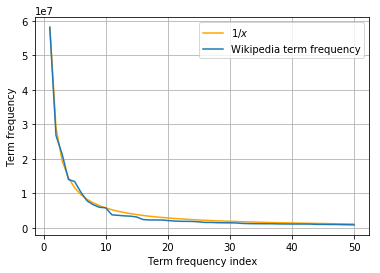

In [6]:
n_plot = 50
x = range(1, n_plot + 1)
plt.plot(x, [y[0] * (1 / x_) for x_ in x], label='1/$x$', color="orange")
plt.plot(x, y[:n_plot], label="Wikipedia term frequency")
plt.xlabel("Term frequency index")
plt.ylabel("Term frequency")
plt.grid()
plt.legend()
plt.savefig("graphs/zipf.pdf", filetype="pdf")
plt.show()

In [7]:
# Compute a quick estimate of the Zipf parameters using the averages of the top 1000 words
offs = 0
n_use = 1000
k = np.mean([i * y[:n_use][i - offs] for i in range(n_use)])
y_sum_ = sum(y[:n_use])
c = np.mean([i * y[:n_use][i - offs] / y_sum_ for i in range(n_use)])
s = 1 - (np.log(c) / np.log(y_sum_ / n_use))
print("Zipf parameters k, c, s =")
k, c, s

Zipf parameters k, c, s =


(63979792.721, 0.1549463077481801, 1.1442020523878902)

In [8]:
# Compute a more exact solution using maximum likelihood estimation, starting from the initial estimate
N = len(y)
x = np.asarray(range(1, len(y) + 1))
y_sum = sum(y)
p = np.asarray(y) / y_sum
zipf_lp = lambda rs, s: -(s * np.log(rs)) - np.log(np.sum(1 / (rs ** s)))
cost = lambda s: np.sum((np.log(p) - zipf_lp(x, s)) ** 2)
res = minimize(cost, s, bounds=[(0.1, 10.0)])
res

      fun: 461803.7549944734
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([8.34115781])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 18
      nit: 6
   status: 0
  success: True
        x: array([1.23159132])

In [9]:
s = res["x"][0]
c = np.mean(x * (1 / x ** s))
k = c * y_sum
print("Zipf parameters k, c, s =")
k, c, s

Zipf parameters k, c, s =


(25199010.333798043, 0.036404389088694214, 1.2315913153103102)

In [67]:
# Define document models. This uses shared memory for (fixed) claims and claims vocab
def tf_idf(doc_tf, total):
    doc_tfidf = {w: ( doc_tf[w] * np.log(N_docs / n_t[w]) ) for w in doc_tf if doc_tf[w] >= 1}
    return [np.sum([doc_tfidf[w] for w in claim["vocab"] if w in doc_tfidf]) for claim in claims]
def unsmoothed_ll(doc_tf, total):
    doc_M = {w: ( doc_tf[w] / total ) for w in doc_tf if doc_tf[w] >= 1}
    res = [np.sum(np.log([doc_M[w] for w in claim["vocab"] if w in doc_M])) for claim in claims]
    return [x if x != 0 else -np.inf for x in res]
def lidstone_ll(doc_tf, total, epsilon=0.05, claims_=[]):
    zero_count_prob = epsilon / (total + (epsilon * N))
    doc_M = {w: ( (doc_tf[w] + epsilon) / (total + (epsilon * N)) ) for w in doc_tf if doc_tf[w] >= 1}
    return [np.sum(np.log([doc_M[w] if w in doc_M else zero_count_prob for w in claim["vocab"]])) for claim in claims_]
log_N_docs = np.log(N_docs + 1) #/ 1
def lidstone_ll_idf(doc_tf, total, epsilon=0.05, claims_=[]):
    zero_count_prob = epsilon * log_N_docs / (total + (epsilon * N))
    doc_M = {w: ( (doc_tf[w] + epsilon) * \
                 (np.log((N_docs + 1) / (n_t[w] + 1))) / (total + (epsilon * N)) ) for w in doc_tf if doc_tf[w] >= 1}
    return [np.sum(np.log([doc_M[w] if w in doc_M else zero_count_prob for w in claim["vocab"]])) for claim in claims_]
# def lidstone_ll(doc_tf, total, epsilon=0.05):
#     doc_M = {w: ( (doc_tf[w] + epsilon) / (total + (epsilon * N)) ) for w in claims_vocab}
#     return [np.sum(np.log([doc_M[w] for w in claim["vocab"]])) for claim in claims]
# def lidstone_ll_idf(doc_tf, total, epsilon=0.05):
#     doc_M = {w: ( (doc_tf[w] + epsilon) * \
#                  (np.log((N_docs + 1) / (n_t[w] + 1))) / (total + (epsilon * N)) ) for w in claims_vocab}
#     return [np.sum(np.log([doc_M[w] for w in claim["vocab"]])) for claim in claims]
def jm_ll(doc_tf, total, lambda_=0.9):
    doc_M = {w: ( (lambda_ * doc_tf[w] / total) + ((1 - lambda_) * c_M_[w]) ) for w in claims_vocab}
    return [np.sum(np.log([doc_M[w] for w in claim["vocab"]])) for claim in claims]
log_cvoc = {(np.log((N_docs + 1) / (n_t[w] + 1)) if n_t[w] > 0 else log_N_docs) for w in claims_vocab}
def create_jm_ll_oods(lambda_):
    return {(1 - lambda_) * c_M_[w] for w in claims_vocab}, \
           {(1 - lambda_) * c_M_[w] * (np.log((N_docs + 1) / (n_t[w] + 1)) if n_t[w] > 0 else log_N_docs) for w in claims_vocab}
def jm_ll_idf(doc_tf, total, lambda_=0.9, oods={}):
    jm_oods, jm_ins = jm_oods
    doc_M = {w: ( ((lambda_ * doc_tf[w] / total) + jm_ins[w]) * log_cvoc[w] ) for w in doc_tf if doc_tf >= 1}
    return [np.sum(np.log([(doc_M[w] if w in doc_M else jm_oods[w]) for w in claim["vocab"]])) for claim in claims]
def dirichlet_ll(doc_tf, total, mu=mean_doc_len):
    doc_M = {w: ( ((total / (total + mu)) * doc_tf[w] / total) + ((mu / (total + mu)) * c_M_[w]) ) for w in claims_vocab}
    return [np.sum(np.log([doc_M[w] for w in claim["vocab"]])) for claim in claims]
def dirichlet_ll_idf(doc_tf, total, mu=mean_doc_len):
    doc_M = {w: ( (((total / (total + mu)) * doc_tf[w] / total) + ((mu / (total + mu)) * c_M_[w])) * \
                 (np.log((N_docs + 1) / (n_t[w] + 1))) ) for w in claims_vocab}
    return [np.sum(np.log([doc_M[w] for w in claim["vocab"]])) for claim in claims]
# Define retrival accuracy (Top-5 recall mean across claims)
# def eval_model(sim_func, **ps):
#     print("Computing similarities (" + str(len(D_ids)) + ")...")
#     similarities = joblib.Parallel(n_jobs=n_cpu, verbose=1)(delayed(sim_func)(*wiki[doc_id], **ps) for doc_id in D_ids)
#     print("Ranking documents...")
#     top_docs = []
#     for i in range(N_claims):
#         sims = [(similarities[j][i], D_ids[j]) for j in range(N_docs)]
#         sims.sort()
#         top_docs.append(sims[-5:])
#     top_docs_ids = [[s[1] for s in s_] for s_ in top_docs]
#     print("Evaluating accuracy...")
#     recall = [np.mean([
#         id_ in top_docs_ids[i] for id_ in set([s[2] for s in sum(claims[i]["evidence"], [])])]) \
#                       for i in range(len(claims))]
#     print(np.mean(recall))
#     return np.mean(recall), top_docs
def batch_sims(docs, sim_func, **ps):
    return [sim_func(*doc, **ps) for doc in docs]
def eval_model(sim_func, **ps):
#     batch_size = (N_docs + 1) // n_cpu
    batch_size = 10000
    D_batches = [D_ids[i * batch_size:(i + 1) * batch_size] for i in range((N_docs // batch_size) + 1)]
    print("Computing similarities (" + str(len(D_ids)) + " in " + str(D_batches) + " batches)...")
    similarities = sum(joblib.Parallel(n_jobs=n_cpu, verbose=5)(delayed(batch_sims)(
        [wiki[doc_id] for doc_id in D_batch], sim_func, **ps) for D_batch in D_batches), [])
    print("Ranking documents...")
    top_docs = []
    for i in range(N_claims):
        sims = [(similarities[j][i], D_ids[j]) for j in range(N_docs)]
        sims.sort()
        top_docs.append(sims[-5:])
        sys_print("\r" + str(i + 1))
    top_docs_ids = [[s[1] for s in s_] for s_ in top_docs]
    print("Evaluating accuracy...")
    recall = [np.mean([
        id_ in top_docs_ids[i] for id_ in set([s[2] for s in sum(claims[i]["evidence"], [])])]) \
                      for i in range(len(claims))]
    print(np.mean(recall))
    return np.mean(recall), top_docs

In [10]:
c_M_ = {w: v for (w, v) in c_M.items() if w in claims_vocab}
len(c_M_)

71

In [51]:
n_t["costerwaldau"]

0

In [62]:
n_t["costerwaldau"]

0

In [65]:
n_t["coster"]

11

In [12]:
claims

[{'id': 75397,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.',
  'evidence': [[[92206, 104971, 'Nikolaj_Coster-Waldau', 7],
    [92206, 104971, 'Fox_Broadcasting_Company', 0]]],
  'vocab': defaultdict(int,
              {'nikolaj': 1,
               'costerwaldau': 1,
               'work': 1,
               'with': 1,
               'the': 1,
               'fox': 1,
               'broadcast': 1,
               'company': 1})},
 {'id': 150448,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Roman Atwood is a content creator.',
  'evidence': [[[174271, 187498, 'Roman_Atwood', 1]],
   [[174271, 187499, 'Roman_Atwood', 3]]],
  'vocab': defaultdict(int,
              {'roman': 1,
               'atwood': 1,
               'be': 1,
               'a': 1,
               'content': 1,
               'creator': 1})},
 {'id': 214861,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim

In [12]:
# Evaluate TF-IDF retrieval
recall, top_docs = eval_model(tf_idf)
print(recall)
pr(top_docs)

Computing similarities...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 61359 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 232859 tasks      | elapsed:   11.0s
[Parallel(n_jobs=8)]: Done 472959 tasks      | elapsed:   20.6s
[Parallel(n_jobs=8)]: Done 781659 tasks      | elapsed:   33.6s
[Parallel(n_jobs=8)]: Done 1158959 tasks      | elapsed:   49.6s
[Parallel(n_jobs=8)]: Done 1592118 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 2108118 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 2670902 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 3322782 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 4027534 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 4793200 tasks      | elapsed:  3.9min
[Parallel(n_jobs=8)]: Done 5396105 out of 5396105 | elapsed:  4.3min finished


Ranking documents...
Evaluating accuracy...
0.1
[   [   (565.4876497407314, 'List_of_New_Jersey_street_railroads'),
        (   578.3046941531861,
            'List_of_early_British_private_locomotive_manufacturers'),
        (578.5329585806993, 'List_of_OMIM_disorder_codes'),
        (919.6459281777633, 'Mottos_and_halls_of_the_Livery_Companies'),
        (1122.005119577352, 'Pteropodinae')],
    [   (235.81835112457279, 'History_of_the_Roman_Constitution'),
        (248.43516166573258, 'List_of_New_Zealand_religious_leaders'),
        (322.0507329044407, 'List_of_New_Zealand_Catholic_bishops'),
        (330.73552851323143, 'List_of_Catholic_schools_in_New_York'),
        (664.7972469445178, 'History_of_Rome_-LRB-disambiguation-RRB-')],
    [   (943.1575493194948, 'Western_literature'),
        (1087.4279817557754, 'List_of_New_Music_America_performances'),
        (1260.1374338558794, 'List_of_national_theatres'),
        (1411.7636848649272, 'List_of_books_by_Jacob_Neusner'),
      

In [112]:
# Evaluate unsmoothed probabilistic retrieval
recall, top_docs = eval_model(unsmoothed_ll)
print(recall)
pr(top_docs)

Computing similarities...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 115783 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 360783 tasks      | elapsed:   12.6s
[Parallel(n_jobs=8)]: Done 541103 tasks      | elapsed:   21.7s
[Parallel(n_jobs=8)]: Done 761603 tasks      | elapsed:   29.1s
[Parallel(n_jobs=8)]: Done 1031103 tasks      | elapsed:   38.0s
[Parallel(n_jobs=8)]: Done 1343081 tasks      | elapsed:   51.7s
[Parallel(n_jobs=8)]: Done 1712081 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 2130281 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 2677201 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 3300853 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 4000053 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 4786501 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 5396106 out of 5396106 | elapsed:  3.4min finished


Ranking documents...
Evaluating accuracy...
0.0
[   [   (-1.0608719606852628, 'The_Last_of_the_Jedi-COLON-_Against_the_Empire'),
        (-1.0296194171811581, 'The_Glitterati_-LRB-album-RRB-'),
        (-1.0116009116784799, 'The_Kabeedies_discography'),
        (-0.9808292530117262, 'On_air'),
        (-0.9555114450274363, 'Public_holidays_in_the_Bahamas')],
    [   (-1.252762968495368, 'List_of_fictional_alien_species-COLON-_A'),
        (-1.1526795099383855, 'C30H50O4'),
        (   -1.0986122886681098,
            'List_of_Members_of_the_Canadian_Senate_-LRB-A-RRB-'),
        (-1.0986122886681098, 'Purpuric_acid'),
        (-1.0986122886681098, 'Reem_-LRB-given_name-RRB-')],
    [   (-0.9007865453381898, 'Portuguese-language_literature'),
        (-0.8690378470236094, 'East_Asian_poetry'),
        (-0.8472978603872037, 'Arts_by_region'),
        (-0.7932306391169278, 'Yugoslav_literature'),
        (-0.6931471805599453, 'Testament_of_Qahat')],
    [   (-1.3862943611198906, 'Diosmeti

In [15]:
# Evaluate Laplace smoothing with Lidstone correction (find an approximation to the best value of epsilon)
res = [eval_model(lidstone_ll, epsilon=e, claims_=claims) for e in [0.0, 0.01, 0.02]]
accs = [r[0] for r in res]
print(accs)
print("Top: ", np.argmax(accs), ",", max(accs))
pr(res[np.argmax(accs)][1])

Computing similarities...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 79693 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 241193 tasks      | elapsed:   24.1s
[Parallel(n_jobs=8)]: Done 374193 tasks      | elapsed:   31.8s
[Parallel(n_jobs=8)]: Done 545193 tasks      | elapsed:   41.1s
[Parallel(n_jobs=8)]: Done 754193 tasks      | elapsed:   52.4s
[Parallel(n_jobs=8)]: Done 1001193 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 1283411 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 1608111 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 1971011 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 2375674 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 2821874 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 3302814 tasks      | elapsed:  3.6min
[Parallel(n_jobs=8)]: Done 3829314 tasks      | elapsed:  4.1min
[Parallel(n_jobs=8)]: Don

Ranking documents...
Evaluating accuracy...
Computing similarities...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 1820 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 89120 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done 234620 tasks      | elapsed:   12.6s
[Parallel(n_jobs=8)]: Done 438320 tasks      | elapsed:   24.2s
[Parallel(n_jobs=8)]: Done 700220 tasks      | elapsed:   38.4s
[Parallel(n_jobs=8)]: Done 1020320 tasks      | elapsed:   57.3s
[Parallel(n_jobs=8)]: Done 1252538 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 1470788 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 1718138 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 1994588 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 2643885 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done 3268649 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 3732399 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 4236469 tasks      | elapsed:  4.4min
[Parallel(n_jobs=8)]: D

Ranking documents...
Evaluating accuracy...
Computing similarities...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 2252 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 117152 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done 308652 tasks      | elapsed:   16.1s
[Parallel(n_jobs=8)]: Done 576752 tasks      | elapsed:   30.6s
[Parallel(n_jobs=8)]: Done 921452 tasks      | elapsed:   48.8s
[Parallel(n_jobs=8)]: Done 1265769 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 1514719 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 1801969 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 2128693 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 2578993 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 3076693 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 3600236 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 4195236 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 4881600 tasks      | elapsed:  4.6min
[Parallel(n_jobs=8)]: 

Ranking documents...
Evaluating accuracy...
[0.35, 0.75, 0.75]
Top:  1 , 0.75
[   [   (-84.44541689134294, 'Peter_Windsor'),
        (-83.9258801318434, 'Mike_Darnell'),
        (-83.73829231177537, "List_of_Bob's_Burgers_episodes"),
        (-83.69045494896842, 'Jimmy_Hodson'),
        (-82.6809317073147, 'Joel_Cheatwood')],
    [   (-65.4835338107251, 'Ríos'),
        (-64.27656109752553, 'List_of_essential_oils'),
        (-63.37445885753884, 'Giancarlo_Volpe'),
        (-62.212551394601164, 'List_of_Latin_legal_terms'),
        (-58.77232788680956, 'List_of_video_game_crowdfunding_projects')],
    [   (-192.93462461778958, 'Fine_art'),
        (-192.1388983819059, 'List_of_Guggenheim_Fellowships_awarded_in_1968'),
        (-191.82440497315247, 'Acropolis_Institute_of_Technology_and_Research'),
        (-189.68519367503376, 'Narrative'),
        (-161.68322013044505, 'History_of_art')],
    [   (-54.28733441438847, 'Jeannie_Mai'),
        (-54.283094129854874, 'Loni_Love'),
        

In [44]:
# Evaluate Laplace + IDF smoothing with Lidstone correction (find an approximation to the best value of epsilon)
res = [eval_model(lidstone_ll_idf, epsilon=e, claims_=claims) for e in [0.0002, 0.001]]
# res = [eval_model(lidstone_ll_idf, epsilon=e, claims_=claims) for e in [0.005, 0.03]]
accs = [r[0] for r in res]
print(accs)
print("Top: ", np.argmax(accs), ",", max(accs))
pr(res[np.argmax(accs)][1])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   30.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  4.6min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=8)]: Done 540 out of 540 | elapsed:  8.5min finished


Ranking documents...
10Evaluating accuracy...
0.15


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   32.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  4.6min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=8)]: Done 540 out of 540 | elapsed:  8.5min finished


Ranking documents...
10Evaluating accuracy...
0.15
[0.15, 0.15]
Top:  0 , 0.15
[   [   (-66.72236242699094, 'The_Big_Picture_with_Thom_Hartmann'),
        (-66.60440966833207, 'Impossible_Pictures_-LRB-US-RRB-'),
        (-65.72186202447739, 'ClearStory'),
        (-64.67743984791383, 'Lar_Lubovitch_Dance_Company'),
        (-60.70588175734058, 'Molly_Dineen')],
    [   (-47.92034900830882, 'OpenSaaS'),
        (-47.8731507161772, 'Google_Lively'),
        (-47.73768520586305, 'Level_editor'),
        (-47.61214290902552, 'PediaPress'),
        (-46.16029802901921, 'Non-fiction')],
    [   (-135.60703531562024, 'Sky_Arts_-LRB-New_Zealand-RRB-'),
        (-131.92235611232604, 'The_arts'),
        (-122.79146710665746, 'Narrative'),
        (-121.27067464492544, 'Fine_art'),
        (-93.51174766080229, 'History_of_art')],
    [   (-42.162482223847036, 'Role_hierarchy'),
        (-42.10744385261369, 'Income_Tax_Appellate_Tribunal'),
        (-41.737359525482226, 'Itzhak_Stern'),
        

In [15]:
# Evaluate Laplace smoothing with Lidstone correction (find an approximation to the best value of epsilon)
res = [eval_model(lidstone_ll, epsilon=e) for e in [0.001]]#, 0.0005, 0.00025]]
accs = [r[0] for r in res]
print(accs)
print("Top: ", np.argmax(accs), ",", max(accs))
pr(res[np.argmax(accs)][1])

Computing similarities...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 79693 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 241193 tasks      | elapsed:   24.1s
[Parallel(n_jobs=8)]: Done 374193 tasks      | elapsed:   31.8s
[Parallel(n_jobs=8)]: Done 545193 tasks      | elapsed:   41.1s
[Parallel(n_jobs=8)]: Done 754193 tasks      | elapsed:   52.4s
[Parallel(n_jobs=8)]: Done 1001193 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 1283411 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 1608111 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 1971011 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 2375674 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 2821874 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 3302814 tasks      | elapsed:  3.6min
[Parallel(n_jobs=8)]: Done 3829314 tasks      | elapsed:  4.1min
[Parallel(n_jobs=8)]: Don

Ranking documents...
Evaluating accuracy...
Computing similarities...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 1820 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 89120 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done 234620 tasks      | elapsed:   12.6s
[Parallel(n_jobs=8)]: Done 438320 tasks      | elapsed:   24.2s
[Parallel(n_jobs=8)]: Done 700220 tasks      | elapsed:   38.4s
[Parallel(n_jobs=8)]: Done 1020320 tasks      | elapsed:   57.3s
[Parallel(n_jobs=8)]: Done 1252538 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 1470788 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 1718138 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 1994588 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 2643885 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done 3268649 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 3732399 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 4236469 tasks      | elapsed:  4.4min
[Parallel(n_jobs=8)]: D

Ranking documents...
Evaluating accuracy...
Computing similarities...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 2252 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 117152 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done 308652 tasks      | elapsed:   16.1s
[Parallel(n_jobs=8)]: Done 576752 tasks      | elapsed:   30.6s
[Parallel(n_jobs=8)]: Done 921452 tasks      | elapsed:   48.8s
[Parallel(n_jobs=8)]: Done 1265769 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 1514719 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 1801969 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 2128693 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 2578993 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 3076693 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 3600236 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 4195236 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 4881600 tasks      | elapsed:  4.6min
[Parallel(n_jobs=8)]: 

Ranking documents...
Evaluating accuracy...
[0.35, 0.75, 0.75]
Top:  1 , 0.75
[   [   (-84.44541689134294, 'Peter_Windsor'),
        (-83.9258801318434, 'Mike_Darnell'),
        (-83.73829231177537, "List_of_Bob's_Burgers_episodes"),
        (-83.69045494896842, 'Jimmy_Hodson'),
        (-82.6809317073147, 'Joel_Cheatwood')],
    [   (-65.4835338107251, 'Ríos'),
        (-64.27656109752553, 'List_of_essential_oils'),
        (-63.37445885753884, 'Giancarlo_Volpe'),
        (-62.212551394601164, 'List_of_Latin_legal_terms'),
        (-58.77232788680956, 'List_of_video_game_crowdfunding_projects')],
    [   (-192.93462461778958, 'Fine_art'),
        (-192.1388983819059, 'List_of_Guggenheim_Fellowships_awarded_in_1968'),
        (-191.82440497315247, 'Acropolis_Institute_of_Technology_and_Research'),
        (-189.68519367503376, 'Narrative'),
        (-161.68322013044505, 'History_of_art')],
    [   (-54.28733441438847, 'Jeannie_Mai'),
        (-54.283094129854874, 'Loni_Love'),
        

In [145]:
# Evaluate Jelinek-Mercer smoothing (find an approximation to the best value of lambda)
res = [eval_model(jm_ll, lambda_=l) for l in [0.5, 0.7, 0.9]]
accs = [r[0] for r in res]
print(accs)
print("Top: ", np.argmax(accs), max(accs))
pr(res[np.argmax(accs)][1])

Computing similarities...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 1980 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 96480 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done 253980 tasks      | elapsed:   11.1s
[Parallel(n_jobs=8)]: Done 474480 tasks      | elapsed:   20.6s
[Parallel(n_jobs=8)]: Done 757980 tasks      | elapsed:   32.9s
[Parallel(n_jobs=8)]: Done 1104480 tasks      | elapsed:   48.3s
[Parallel(n_jobs=8)]: Done 1432080 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 1668330 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 2147645 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 2748641 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 3083591 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 3450441 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done 3849191 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 4279361 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: D

Ranking documents...
Evaluating accuracy...
Computing similarities...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 2460 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 118560 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done 312060 tasks      | elapsed:   15.3s
[Parallel(n_jobs=8)]: Done 534585 tasks      | elapsed:   32.7s
[Parallel(n_jobs=8)]: Done 708735 tasks      | elapsed:   41.2s
[Parallel(n_jobs=8)]: Done 921585 tasks      | elapsed:   50.9s
[Parallel(n_jobs=8)]: Done 1173135 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 1463385 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 1792335 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 2171617 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 2595817 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 3060417 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 3627585 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 4291785 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: D

Ranking documents...
Evaluating accuracy...
Computing similarities...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 2420 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 122720 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done 323220 tasks      | elapsed:   16.2s
[Parallel(n_jobs=8)]: Done 603920 tasks      | elapsed:   29.8s
[Parallel(n_jobs=8)]: Done 964820 tasks      | elapsed:   47.5s
[Parallel(n_jobs=8)]: Done 1218653 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 1479303 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 1780053 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 2120903 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 2511131 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 2981531 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 3496731 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 4058871 tasks      | elapsed:  3.6min
[Parallel(n_jobs=8)]: Done 4690671 tasks      | elapsed:  4.1min
[Parallel(n_jobs=8)]: 

Ranking documents...
Evaluating accuracy...
[0.5, 0.5, 0.5]
Top:  0 0.5
[   [   (-58.531016135672424, 'List_of_Family_Guy_writers'),
        (-57.57187670279971, 'List_of_The_Simpsons_writers'),
        (-53.98220115472991, 'The_Other_Woman_-LRB-2014_film-RRB-'),
        (-49.579533699869394, 'Nikolaj_Coster-Waldau'),
        (-43.5054767094514, 'New_Amsterdam_-LRB-TV_series-RRB-')],
    [   (-40.73525432621581, 'MTV_Southeast_Asia'),
        (-40.266095811714166, 'Joel_Spolsky'),
        (-39.81394791601179, 'Tosyn_Bucknor'),
        (-39.445277325249464, 'Stacey_Roy'),
        (-38.501777777036416, 'Only_Much_Louder')],
    [   (-124.02107048422931, 'Art'),
        (-121.04149647295692, 'The_arts'),
        (-116.58172911496521, 'Fine_art'),
        (-115.80240871859752, 'Narrative'),
        (-87.88938572123809, 'History_of_art')],
    [   (-32.97624879417484, "All_You've_Got"),
        (-32.21122427985594, 'Jeannie_Mai'),
        (-32.11010435251731, 'Cheetah-licious_Christmas'),
 

In [50]:
# Evaluate Jelinek-Mercer + IDF smoothing (find an approximation to the best value of lambda)
res = [eval_model(jm_ll_idf, claims_=claims, lambda_=l, oods=create_jm_ll_oods(l)) for l in [0.9, 0.95, 0.8, 0.7, 0.5]]
accs = [r[0] for r in res]
print(accs)
print("Top: ", np.argmax(accs), max(accs))
pr(res[np.argmax(accs)][1])

KeyError: 'costerwaldau'

In [146]:
# Evaluate Dirichlet smoothing
recall, top_docs = eval_model(dirichlet_ll)
print(recall)
pr(top_docs)

Computing similarities...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 34270 tasks      | elapsed:   10.6s
[Parallel(n_jobs=8)]: Done 91520 tasks      | elapsed:   14.8s
[Parallel(n_jobs=8)]: Done 171670 tasks      | elapsed:   20.8s
[Parallel(n_jobs=8)]: Done 274720 tasks      | elapsed:   29.9s
[Parallel(n_jobs=8)]: Done 400670 tasks      | elapsed:   42.5s
[Parallel(n_jobs=8)]: Done 549520 tasks      | elapsed:   56.1s
[Parallel(n_jobs=8)]: Done 721270 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 915920 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 1133470 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 1373920 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done 1637270 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 1923376 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 2236576 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 25

Ranking documents...
Evaluating accuracy...
0.5
[   [   (-53.531954283430366, 'Nukaaka_Coster-Waldau'),
        (-52.4639301714163, 'Ved_verdens_ende'),
        (-50.94713795197959, 'The_Other_Woman_-LRB-2014_film-RRB-'),
        (-47.82094977890843, 'Nikolaj_Coster-Waldau'),
        (-42.52483761859257, 'New_Amsterdam_-LRB-TV_series-RRB-')],
    [   (-39.053651309848135, 'Only_Much_Louder'),
        (-38.93302621492668, 'Genre_fiction'),
        (-38.84531453534413, 'Bedside_Press'),
        (-37.91645578641158, 'Stacey_Roy'),
        (-37.76912397438327, 'Joel_Spolsky')],
    [   (-118.79164875093902, 'Sky_Arts_-LRB-New_Zealand-RRB-'),
        (-114.57134505287016, 'The_arts'),
        (-113.34756136354326, 'Narrative'),
        (-112.54071303404504, 'Fine_art'),
        (-89.43100720235788, 'History_of_art')],
    [   (-31.53023906116086, 'Cheetah-licious_Christmas'),
        (-31.33001220850123, '3LW'),
        (-30.89974732390236, "All_You've_Got"),
        (-30.542418101056334, '

In [15]:
# import spacy
# nlp = spacy.load('en', disable=['parser', 'ner'])
# [token.lemma_ for token in nlp("produce production producing produced producer's product products create creator")]

['produce',
 'production',
 'produce',
 'produce',
 'producer',
 "'s",
 'product',
 'product',
 'create',
 'creator']

In [20]:
# [token.lemma_ for token in nlp("")]

[]

In [132]:
# similarities = [jm_ll(*wiki[doc_id]) for doc_id in D_ids]
# print("Ranking documents...")
# top_docs = []
# for i in range(N_claims):
#     sims = [(similarities[j][i], D_ids[j]) for j in range(N_docs)]
#     sims.sort()
#     top_docs.append(sims[-5:])
# top_docs_ids = [[s[1] for s in s_] for s_ in top_docs]
# print("Evaluating accuracy...")
# recall = [np.mean([
#     id_ in top_docs_ids[i] for id_ in set([s[2] for s in sum(claims[i]["evidence"], [])])]) \
#                   for i in range(len(claims))]
# np.mean(recall), top_docs

wat defaultdict(<class 'int'>, {'hunger': 0})


ZeroDivisionError: float division by zero

In [88]:
# claims

[{'id': 75397,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.',
  'evidence': [[[92206, 104971, 'Nikolaj_Coster-Waldau', 7],
    [92206, 104971, 'Fox_Broadcasting_Company', 0]]],
  'vocab': defaultdict(int,
              {'nikolaj': 1,
               'costerwaldau': 1,
               'worked': 1,
               'with': 1,
               'the': 1,
               'fox': 1,
               'broadcasting': 1,
               'company': 1})},
 {'id': 150448,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Roman Atwood is a content creator.',
  'evidence': [[[174271, 187498, 'Roman_Atwood', 1]],
   [[174271, 187499, 'Roman_Atwood', 3]]],
  'vocab': defaultdict(int,
              {'roman': 1,
               'atwood': 1,
               'is': 1,
               'a': 1,
               'content': 1,
               'creator': 1})},
 {'id': 214861,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  '

In [13]:
# claim_ids = [75397, 150448, 214861, 156709, 129629, 33078, 6744, 226034, 40190, 76253]
# claims = []
# claims_vocab = set()
# with open(data_dir + "train.jsonl", 'r') as f:
#     a = jsonlines.Reader(f)
#     for a_ in a:
#         if a_["id"] in claim_ids:
#             claims.append(a_)
#             claims[-1]["vocab"] = defaultdict(int)
#             for w in a_["claim"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", ''). \
#               translate(punc_trans).lower().split():
#                 claims[-1]["vocab"][w] += 1
#                 claims_vocab.add(w)

In [15]:
# N_docs = 0
# n_t = defaultdict(int)
# i_ = 0
# for fn in fs:
#     with open(fn, 'r') as f:
#         a = jsonlines.Reader(f)
#         for a_ in a:
#             if a_["id"] == "":
#                 continue
#             N_docs += 1
#             entry = [[w.translate(punc_trans).lower() for w in l.split()[1:] if w != \
#                      '' and not ((any(c.isnumeric() for c in w) and len(w) > 7) or \
#                                  (w.isnumeric() and len(w) > 5))] for l in a_[
#                     "lines"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", '').split('\n') if \
#                      len(l) > 0 and not (len(l) == 1 and l[0].isnumeric())]
#             for w in set(sum(entry, [])):
#                 if w in claims_vocab:
#                     n_t[w] += 1
#     i_ += 1
#     sys_print("\r" + str(i_))
# N_docs

109

5416536

In [19]:
# # Load each document and measure cosine similarity
# similarities = {}
# i_ = 0
# for fn in fs:
#     with open(fn, 'r') as f:
#         a = jsonlines.Reader(f)
#         for a_ in a:
#             if a_["id"] == "":
#                 continue
#             doc_tf = defaultdict(int)
#             for l in ([w.translate(punc_trans).lower() for w in l.split()[1:] if w != \
#                      '' and not ((any(c.isnumeric() for c in w) and len(w) > 7) or \
#                                  (w.isnumeric() and len(w) > 5))] for l in a_[
#                     "lines"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", '').split('\n') if \
#                      len(l) > 0 and not (len(l) == 1 and l[0].isnumeric())):
#                 for w in l:
#                     if w in claims_vocab:
#                         doc_tf[w] += 1
#             doc_tf = {w: doc_tf[w] * np.log(N_docs / n_t[w]) for w in doc_tf}
#             similarities[a_["id"]] = [sum([doc_tf[w] for w in claim["vocab"] if w in doc_tf]) for claim in claims]
#     i_ += 1
#     sys_print("\r" + str(i_))
# similarities = list(similarities.items())

109

In [22]:
# top_docs = []
# for i in range(10):
#     sims = [(s[1][i], s[0]) for s in similarities]
#     sims.sort()
#     top_docs.append(sims[-5:])
# top_docs

[[(566.179224990433, 'List_of_New_Jersey_street_railroads'),
  (579.0265022006889,
   'List_of_early_British_private_locomotive_manufacturers'),
  (580.2826817534418, 'List_of_OMIM_disorder_codes'),
  (920.8325654914589, 'Mottos_and_halls_of_the_Livery_Companies'),
  (1122.7571604226562, 'Pteropodinae')],
 [(236.04509710808153, 'History_of_the_Roman_Constitution'),
  (248.6656867489665, 'List_of_New_Zealand_religious_leaders'),
  (322.341723583277, 'List_of_New_Zealand_Catholic_bishops'),
  (331.034077391518, 'List_of_Catholic_schools_in_New_York'),
  (665.3830074019156, 'History_of_Rome_-LRB-disambiguation-RRB-')],
 [(943.9322647631498, 'Western_literature'),
  (1089.2646242221958, 'List_of_New_Music_America_performances'),
  (1261.5168052555575, 'List_of_national_theatres'),
  (1418.3355392869555, 'List_of_books_by_Jacob_Neusner'),
  (1574.613579602451,
   'List_of_artists_in_the_Philadelphia_Museum_of_Art_handbook_of_the_collections')],
 [(127.08135108472278, 'List_of_This_Is_Daniel

In [26]:
# # Query-likelihood unigram language modelling (unsmoothed)
# def prod(xs):
#     if len(xs) == 0:
#         return 0
#     if len(xs) > 1:
#         return xs[0] * prod(xs[1:])
#     return xs[0]
# likelihoods = {}
# i_ = 0
# for fn in fs:
#     with open(fn, 'r') as f:
#         a = jsonlines.Reader(f)
#         for a_ in a:
#             if a_["id"] == "":
#                 continue
#             doc_M = defaultdict(int)
#             total = 0
#             for l in ([w.translate(punc_trans).lower() for w in l.split()[1:] if w != \
#                      '' and not ((any(c.isnumeric() for c in w) and len(w) > 7) or \
#                                  (w.isnumeric() and len(w) > 5))] for l in a_[
#                     "lines"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", '').split('\n') if \
#                      len(l) > 0 and not (len(l) == 1 and l[0].isnumeric())):
#                 for w in l:
#                     if w in claims_vocab:
#                         doc_M[w] += 1
#                     total += 1
#             doc_M = {w: doc_M[w] / total for w in doc_M}
#             likelihoods[a_["id"]] = [prod([doc_M[w] for w in claim["vocab"] if w in doc_M]) for claim in claims]
#     i_ += 1
#     sys_print("\r" + str(i_))
# likelihoods = list(likelihoods.items())

109

In [27]:
# top_docs_us = []
# for i in range(10):
#     sims = [(s[1][i], s[0]) for s in likelihoods]
#     sims.sort()
#     top_docs_us.append(sims[-5:])
# top_docs_us

[[(0.34615384615384615, 'The_Last_of_the_Jedi-COLON-_Against_the_Empire'),
  (0.35714285714285715, 'The_Glitterati_-LRB-album-RRB-'),
  (0.36363636363636365, 'The_Kabeedies_discography'),
  (0.375, 'On_air'),
  (0.38461538461538464, 'Public_holidays_in_the_Bahamas')],
 [(0.2857142857142857, 'List_of_fictional_alien_species-COLON-_A'),
  (0.3157894736842105, 'C30H50O4'),
  (0.3333333333333333, 'List_of_Members_of_the_Canadian_Senate_-LRB-A-RRB-'),
  (0.3333333333333333, 'Purpuric_acid'),
  (0.3333333333333333, 'Reem_-LRB-given_name-RRB-')],
 [(0.40625, 'Portuguese-language_literature'),
  (0.41935483870967744, 'East_Asian_poetry'),
  (0.42857142857142855, 'Arts_by_region'),
  (0.4523809523809524, 'Yugoslav_literature'),
  (0.5, 'Testament_of_Qahat')],
 [(0.25, 'Diosmetinidin'),
  (0.25, 'Ruether'),
  (0.2608695652173913, 'List_of_DC_Comics_characters-COLON-_K'),
  (0.3333333333333333, 'Purpuric_acid'),
  (0.3333333333333333, 'Reem_-LRB-given_name-RRB-')],
 [(0.373134328358209, 'Constitu

In [47]:
# # Import wikipedia dataset document word counts for the claim vocabulary
# wiki = {}
# i_ = 0
# for fn in fs:
#     with open(fn, 'r') as f:
#         a = jsonlines.Reader(f)
#         for a_ in a:
#             if a_["id"] == "":
#                 continue
#             doc_M = defaultdict(int)
#             total = 0
#             for l in ([w.translate(punc_trans).lower() for w in l.split()[1:] if w != \
#                      '' and not ((any(c.isnumeric() for c in w) and len(w) > 7) or \
#                                  (w.isnumeric() and len(w) > 5))] for l in a_[
#                     "lines"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", '').split('\n') if \
#                      len(l) > 0 and not (len(l) == 1 and l[0].isnumeric())):
#                 for w in l:
#                     if w in claims_vocab:
#                         doc_M[w] += 1
#                     total += 1
#             wiki[a_["id"]] = doc_M, total
#     i_ += 1
#     sys_print("\r" + str(i_))
# N_docs = len(wiki)
# N_docs

5416536

In [49]:

# top_docs_ls

[[(-93.88792155564518, 'Peter_Windsor'),
  (-93.3362426640573, 'Mike_Darnell'),
  (-93.2490523905636, "List_of_Bob's_Burgers_episodes"),
  (-93.14458474306068, 'Jimmy_Hodson'),
  (-92.12060364493253, 'Joel_Cheatwood')],
 [(-71.50651994917307, 'Ríos'),
  (-71.29546258204249, 'Giancarlo_Volpe'),
  (-70.35450291570794, 'List_of_essential_oils'),
  (-67.08361379838946, 'List_of_Latin_legal_terms'),
  (-64.71084161996984, 'List_of_video_game_crowdfunding_projects')],
 [(-212.1720252860265, 'List_of_New_Music_America_performances'),
  (-211.8780699805498, 'Narrative'),
  (-211.516743391354, 'List_of_Guggenheim_Fellowships_awarded_in_1968'),
  (-209.68037646198567, 'Acropolis_Institute_of_Technology_and_Research'),
  (-190.23549854041386, 'History_of_art')],
 [(-60.642762136163455, 'Loni_Love'),
  (-60.63228118073983, 'Jeannie_Mai'),
  (-60.41817178428785, 'Roy_"Royalty"_Hamilton'),
  (-60.251009380271654, 'Tamar_Braxton'),
  (-59.94750735936245, 'Adrienne_Bailon')],
 [(-169.6512907398757, 'L

0.75

In [31]:
# claims

[{'id': 75397,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.',
  'evidence': [[[92206, 104971, 'Nikolaj_Coster-Waldau', 7],
    [92206, 104971, 'Fox_Broadcasting_Company', 0]]],
  'vocab': defaultdict(int,
              {'nikolaj': 1,
               'costerwaldau': 1,
               'worked': 1,
               'with': 1,
               'the': 1,
               'fox': 1,
               'broadcasting': 1,
               'company': 1})},
 {'id': 150448,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Roman Atwood is a content creator.',
  'evidence': [[[174271, 187498, 'Roman_Atwood', 1]],
   [[174271, 187499, 'Roman_Atwood', 3]]],
  'vocab': defaultdict(int,
              {'roman': 1,
               'atwood': 1,
               'is': 1,
               'a': 1,
               'content': 1,
               'creator': 1})},
 {'id': 214861,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  '